In [1]:
%matplotlib
from tools.fpm_runner import set_composition, show, run, plot, read_envels, get_stable, crossed_point, LOG
from glob import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, widget, fixed, FloatSlider
from matplotlib.widgets import Slider, Button

import numpy as np

import pandas as pd

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rc('lines', linewidth=0.7)#, marker="o", markersize=0.25)
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

Using matplotlib backend: <object object at 0x7f4b1457a2a0>


In [2]:
def get_cp():
    points = {}
    for file in glob("env23out/*CP"):  
        
        with open(file) as f:
            lines = f.readlines()
        
        if len(lines) > 1:
            print(file)
            points[file] = {"t": [], "p": []}
            
            for line in lines[1:]:
                t, p = line.split()
                
                t = float(t)
                p = float(p)
                
                points[file]["t"].append(t)
                points[file]["p"].append(p)
    return points

def run_range(
    infile, 
    rank, 
    stable=True, 
    three_phase=True,
    **run_kwargs,
    ):
    for i in rank:
        print(i)
        z = set_composition(infile, -1, i)
        run(
            "new_file", 
            three_phase="yes" if three_phase else "",
            profile="release",
            **run_kwargs
        )

        ax = plot(
            stable=stable,
            label=f"{z[-1]*100:.3f}%",
            alpha=1 - 0.8 * abs(max(rank) - i)/abs(max(rank) - min(rank))
        )
        plot_crit()

def plot_crit():
    points = get_cp()

    for file in points:
        criticals = points[file]
        for t, p in zip(criticals["t"], criticals["p"]):
            plt.scatter(t, p, color="black", s=10)

# Case 1

env23out/envelout3-CROSS21-CP
env23out/envelout2-LTBUB-CP


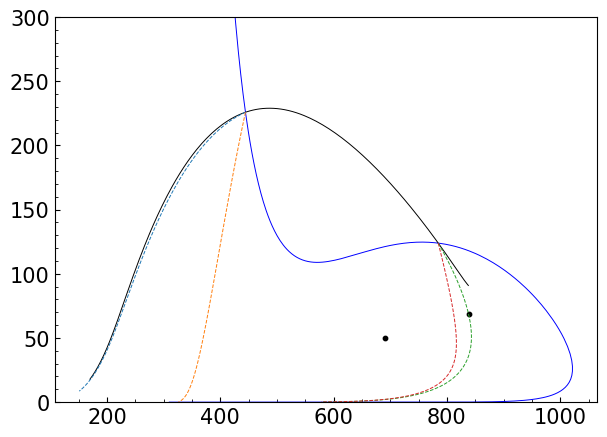

In [3]:
%matplotlib inline
infile = 'infiles/case1'

#z = [0.0248, 0.3723]
# z = set_composition(infile, -1, 0.0004)
run(
    infile, 
    three_phase="yes",
    #flag="-freal-8-real-16"
)

plot(stable=False)
plot_crit()

plt.ylim(0, 300)
plt.show()

In [4]:
envels = read_envels()

In [5]:
%matplotlib
dew = envels["2phase"][0]
bub = envels["2phase"][1]

prop = [f"K{i}" for i in range(1, 9, 3)]

plt.plot(dew["T"], dew[prop])

plt.gca().set_prop_cycle(None)
plt.plot(bub["T"], bub[prop])

plt.legend(prop)

Using matplotlib backend: QtAgg


In [6]:
%matplotlib
dew = envels["2phase"][0]
bub = envels["2phase"][1]

prop = [f"K{i}" for i in range(1, 9, 3)]

plt.gca().set_prop_cycle(None)

for c in prop:
    plt.scatter(bub.index, bub[c])

plt.legend(prop)

len(bub) - 251

Using matplotlib backend: QtAgg


14

# Case 2

- DSP Transition
- Overlaped envelopes

In [7]:
infile = 'infiles/case2'

comps = (
    "N2",
    "CO2",
    "H2S",
    "C1",
    "C2",
    "C3",
    "iC4",
    "nC4",
    "iC5",
    "nC5",
    "C6",
    "C7-C25",
    "C26-C49",
    "C50-C64-PN",
    "C65-C80-PN",
    "C50-C80-A"
)

n_comps = len(comps)

components = {}
sliders = {}
for comp, conc in zip(comps, set_composition(infile)):
    components[comp] = conc
    sliders[comp] = FloatSlider(
        min=conc*0.5,
        max=conc*1.5,
        step=conc/10
    )

## Interactive

In [8]:
%matplotlib
LOG = True
plt.ion()

@interact(
    infile=fixed(infile),
    **sliders
)
def interactive_run(
        infile, **kwargs
    ):
    z = np.array([kwargs[comp] for comp in kwargs])
    z = z/z.sum()

    plt.clf()

    z = set_composition(infile, z=z)
    run(
        "new_file", 
        three_phase="yes",
        profile="release"
    )

    plot(stable=False)
    plot_crit()

    plt.ylim(-1, 300)
    plt.show()

    return z

Using matplotlib backend: QtAgg


interactive(children=(FloatSlider(value=0.00245, description='N2', max=0.00735, min=0.00245, step=0.00049), Fl…

In [9]:
%matplotlib widget

# z = np.array([0.00483514, 0.11218504, 0.03177376, 0.26994864, 0.09284449,
#        0.06610323, 0.00799278, 0.04301051, 0.01354332, 0.0195379 ,
#        0.02457039, 0.24943384, 0.05450876, 0.00537786, 0.00180578,
#        0.00252858])

envels = read_envels()

bub = envels["3phase"][0]
laop = envels["3phase"][1]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))

msk = list(range(1, len(comps)+1, 1))

# =================================

k = [f"K{i}" for i in msk]
ks = [f"KS{i}" for i in msk]

k_ks = [f"K/KS{i}" for i in msk]

bub.loc[:, k_ks] = bub[k].values/bub[ks].values
laop.loc[:, k_ks] = laop[k].values/laop[ks].values

# =================================

# axes[0, 0].plot(bub["T"], bub[k], alpha=0.5)
# axes[0, 0].set_prop_cycle(None)
axes[0, 0].plot(laop["T"], laop[ks], ls="--")
axes[0, 0].set_title("LAOP: KS, BUB: K")

# =================================

# axes[0, 1].plot(bub["T"], bub[k], alpha=0.5)
# axes[0, 1].set_prop_cycle(None)
axes[0, 1].plot(laop["T"], laop[k], ls="--")
axes[0, 1].set_title("LAOP: K, BUB: K")

# =================================

# axes[0, 2].plot(bub["T"], bub[ks], alpha=0.5)
# axes[0, 2].set_prop_cycle(None)
axes[0, 2].plot(laop["T"], laop[ks], ls="--")
axes[0, 2].set_title("LAOP: KS, BUB: KS")

# =================================

# axes[1, 0].plot(bub["T"], bub[k_ks], alpha=0.5)
# axes[1, 0].set_prop_cycle(None)
axes[1, 0].plot(laop["T"], laop[ks], ls="--")
axes[1, 0].set_title("LAOP: KS, BUB: K/KS")

# =================================

# axes[1, 1].plot(bub["T"], bub[ks], alpha=0.5)
# axes[1, 1].set_prop_cycle(None)
axes[1, 1].plot(laop["T"], laop[k_ks], ls="--")

axes[1, 1].set_title("LAOP: K/KS, BUB: KS")


# =================================

# axes[1, 2].plot(bub["T"], bub[k], alpha=0.5)
# axes[1, 2].set_prop_cycle(None)
axes[1, 2].plot(laop["T"], laop[k_ks], ls="--")
axes[1, 2].set_title("LAOP: K/KS, BUB: K/KS")


fig.suptitle("Continous: BUB, DASHED: LAOP")
plt.legend(comps)
plt.show()

In [21]:
%matplotlib widget
# Define base case
infile = "infiles/case2"

# Rank of asphaltenes composition to analize
rank = np.linspace(0.0010, 0.0015, 5)

run_range(infile, rank, stable=False, three_phase=False)

ax = plt.gcf().get_axes()[0]
h, l = ax.get_legend_handles_labels()

# plt.legend(handles=h[::2], labels=l[::2])
plt.title("DSP transition: Asphaltenes variation")

plt.show()

0.001
env23out/envelout2-DEW-CP
env23out/envelout2-LTBUB-CP
0.0011250000000000001
env23out/envelout2-DEW-CP
env23out/envelout2-LTBUB-CP
0.00125
env23out/envelout2-LTBUB-CP
0.001375
env23out/envelout2-LTBUB-CP
0.0015
env23out/envelout2-LTBUB-CP


In [23]:
%matplotlib
# Define base case
infile = "infiles/case2"

# Rank of asphaltenes composition to analize
rank = np.linspace(0.0010, 0.0012, 3)

# run_range(infile, rank, stable=False, three_phase=False)

z = set_composition(infile, -1, 0.0015)
run(
    "new_file", 
    three_phase="yes",
)

plot(stable=True)

plot_crit()

plt.title("DSP transition: Asphaltenes variation")
plt.show()

Using matplotlib backend: QtAgg
env23out/envelout2-LTBUB-CP


In [ ]:
dew = pd.read_csv("env23out/envelout2-DEW", delim_whitespace=True)
bub = pd.read_csv("env23out/envelout2-LTBUB", delim_whitespace=True)

prop = "P"

plt.plot(dew["T"], dew[prop])
plt.plot(bub["T"], bub[prop])

plt.legend(["dew", "bub"])

plt.xlabel("T [K]")
plt.ylabel("P [bar]")
plt.tight_layout()

In [ ]:
prop = [f"K{i}" for i in range(1, 9)]

# plt.plot(dew["T"], dew[prop])
# plt.gca().set_prop_cycle(None)
plt.plot(bub.index, bub[prop])

plt.legend(
    comps, ncols=1, loc="center", bbox_to_anchor=(0.5, 0.25, 1.5, 0.5)
)

plt.xlabel("T [K]")
plt.ylabel("$\ln K$")
plt.tight_layout()
plt.show()

### Case2': Overpaped envelopes

In [ ]:
%matplotlib

infile = 'infiles/case2pri'

z = set_composition(infile)
run(
    "new_file", 
    three_phase="yes",
    # flag="-freal-8-real-16"
)

plot(stable=False)

plt.ylim(0, 300)
plt.show()

In [ ]:
%matplotlib widget

fig, ax = plt.subplots()
envels = read_envels()

index = "T"

numbers = [i for i in range(n_comps)]

prop = [f"x{i+1}" for i in numbers]
show(envels["3phase"][-2], index, prop, alpha=0.5)
plt.gca().set_prop_cycle(None)

prop = [f"y{i+1}" for i in numbers]
show(envels["3phase"][-2], index, prop, alpha=0.5)
plt.gca().set_prop_cycle(None)

prop = [f"w{i+1}" for i in numbers]
show(envels["3phase"][-2], index, prop, alpha=0.5)

#prop = [f"KS{i+1}" for i in numbers]
#show(envels["3phase"][-1], index, prop, alpha=0.5)

ax.set_xlabel(r"$T\ [K]$")
ax.set_ylabel(r"$K = \frac{y_i}{x_i}$")
ax.tick_params(direction="in")

lgnd = plt.legend(
    comps[numbers],
    bbox_to_anchor=(1.3, 0.5),
    loc="center right",
    frameon=False,
    fontsize=11
)

plt.tight_layout()
#plt.xlim(600, None)
#plt.ylim(0, 5)
plt.show()

In [ ]:
%matplotlib inline

[
    plt.plot(
        envels["3phase"][-1]["T"],
        envels["3phase"][-1][x]
    ) for x in ["x2", "y2", "w2"]
    
]
plt.gca().set_prop_cycle(None)

[
    plt.plot(
        envels["3phase"][-2]["T"],
        envels["3phase"][-2][x]
    ) for x in ["x2", "y2", "w2"]
    
]

# plt.title()

In [ ]:
msk_1 = envels["3phase"][-1]["T"].diff() < 0
envel_1 = envels["3phase"][-1][msk_1]

msk_2 = (
    (envel_1["T"].min() < envels["3phase"][-2]["T"])
    &
    (envels["3phase"][-2]["T"] < envel_1["T"].max())
    ) 

envel_2 = envels["3phase"][-2][msk_2]

plt.plot(envel_1["T"], envel_1["P"], alpha=0.5, color="red")
plt.plot(envel_2["T"], envel_2["P"], alpha=0.5)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()

comp = 11
[
    plt.plot(
        envel_1["T"],
        envel_1[x], label=x, color="red"
    ) for x in [f"x{comp}", f"y{comp}", f"w{comp}"]
    
]
plt.gca().set_prop_cycle(None)

[
    plt.plot(
        envel_2["T"],
        envel_2[x], color="green", alpha=0.3, ls='--'
    ) for x in [f"x{comp}", f"y{comp}", f"w{comp}"]
    
]

plt.xlabel("T")
plt.ylabel("x,y,w")
plt.legend()
plt.show()

In [ ]:
%matplotlib inline

plt.clf()
props = ["KS1", "KS2"]

plt.plot(envel_1["T"], envel_1[props], color="red")
plt.plot(envel_2["T"], 1/envel_2[props], color="green")

plt.ylabel(r"$K_s$")
plt.xlabel("T")

plt.show()

In [ ]:
%matplotlib inline

# Converting envel 2 Ks to K
envel_2.loc[:, ["KS1/K1", "KS2/K2"]] = envel_2[["KS1", "KS2"]].values / envel_2[props].values

props = ["K1", "K2"]

plt.plot(envel_1["T"], envel_1[props], color="red")
plt.plot(envel_2["T"], 1/envel_2[["KS1/K1", "KS2/K2"]], color="green")

plt.ylabel(r"$K$")
plt.xlabel("T")

plt.show()

In [ ]:
_ = envels["3phase"][-1]
_2 = envels["3phase"][-2]

_.loc[:, ["KS1/K1", "KS2/K2"]] = 1/(_[["KS1", "KS2"]].values / _[props].values)

plt.plot(_["T"], _[["KS1/K1", "KS2/K2"]], color="red")
plt.plot(_2["T"], _2[["K1", "K2"]], color="green")